### Importar Libs

In [1]:
import os
import subprocess
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

import re

import skrub
from skrub import GapEncoder, SimilarityEncoder

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, PredictionErrorDisplay

from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-09-10T23:41:17.525118-03:00

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.15.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

skrub     : 0.0.1.dev0
numpy     : 1.25.2
pandas    : 2.1.0
sklearn   : 1.3.0
re        : 2.2.1
matplotlib: 3.7.2
seaborn   : 0.12.2



### Variaveis de Ambiente

In [5]:
path_dados = 'laptop-prices/'
data = 'laptop_price.csv'

### Importar Dados

In [6]:
df_laptop = pd.read_csv(path_dados + data, sep = ',', encoding = 'latin-1')
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.690
1,2,Apple,Macbook Air,Ultrabook,13.300,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.940
2,3,HP,250 G6,Notebook,15.600,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.000
3,4,Apple,MacBook Pro,Ultrabook,15.400,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.450
4,5,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.600


In [7]:
print(df_laptop.shape)

(1303, 13)


In [8]:
df_laptop.columns

Index(['laptop_ID', 'Company', 'Product', 'TypeName', 'Inches',
       'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight',
       'Price_euros'],
      dtype='object')

### Extração de Features

In [9]:
# Criando Features Numéricas - Ram
df_laptop['Ram(GB)'] = pd.to_numeric(df_laptop['Ram'].str.replace('GB', ''))
df_laptop = df_laptop.drop('Ram', axis=1)
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,Weight,Price_euros,Ram(GB)
0,1,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.690,8
1,2,Apple,Macbook Air,Ultrabook,13.300,1440x900,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.940,8
2,3,HP,250 G6,Notebook,15.600,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.000,8
3,4,Apple,MacBook Pro,Ultrabook,15.400,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.450,16
4,5,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.600,8


In [10]:
# Criando Features - Weigth
df_laptop['Weight(Kg)'] = pd.to_numeric(df_laptop['Weight'].str.replace('kg', ''))
df_laptop = df_laptop.drop('Weight', axis=1)
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Memory,Gpu,OpSys,Price_euros,Ram(GB),Weight(Kg)
0,1,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,128GB SSD,Intel Iris Plus Graphics 640,macOS,1339.690,8,1.370
1,2,Apple,Macbook Air,Ultrabook,13.300,1440x900,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,macOS,898.940,8,1.340
2,3,HP,250 G6,Notebook,15.600,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,No OS,575.000,8,1.860
3,4,Apple,MacBook Pro,Ultrabook,15.400,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,512GB SSD,AMD Radeon Pro 455,macOS,2537.450,16,1.830
4,5,Apple,MacBook Pro,Ultrabook,13.300,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,256GB SSD,Intel Iris Plus Graphics 650,macOS,1803.600,8,1.370


In [11]:
# Criando Features - ScreenResolution
# Trazer features de Resolution, Screentype e Touchscreen
df_laptop['Resolution'] = df_laptop['ScreenResolution'].str.extract(r'(\d+x\d+)')

df_laptop['Screentype'] = df_laptop['ScreenResolution'].replace(r'(\d+x\d+)', '', regex=True)
df_laptop['Screentype'] = df_laptop['Screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)', '', regex=True)

df_laptop['Touchscreen'] = df_laptop['Screentype'].str.extract(r'(Touchscreen)')
df_laptop['Screentype'] = df_laptop['Screentype'].replace(r'(Touchscreen)', '', regex=True)

df_laptop['Touchscreen'] = df_laptop['Touchscreen'].replace('Touchscreen',1)
df_laptop['Touchscreen'] = df_laptop['Touchscreen'].replace(np.nan,0)

df_laptop['Screentype'] = df_laptop['Screentype'].replace(r' ','',regex=True)
df_laptop['Screentype'] = df_laptop['Screentype'].replace(r'^\s*$', np.nan, regex=True)

df_laptop = df_laptop.drop('ScreenResolution', axis=1)

df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,Cpu,Memory,Gpu,OpSys,Price_euros,Ram(GB),Weight(Kg),Resolution,Screentype,Touchscreen
0,1,Apple,MacBook Pro,Ultrabook,13.300,Intel Core i5 2.3GHz,128GB SSD,Intel Iris Plus Graphics 640,macOS,1339.690,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000
1,2,Apple,Macbook Air,Ultrabook,13.300,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,macOS,898.940,8,1.340,1440x900,NaN,0.000
2,3,HP,250 G6,Notebook,15.600,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,No OS,575.000,8,1.860,1920x1080,NaN,0.000
3,4,Apple,MacBook Pro,Ultrabook,15.400,Intel Core i7 2.7GHz,512GB SSD,AMD Radeon Pro 455,macOS,2537.450,16,1.830,2880x1800,IPSPanelRetinaDisplay,0.000
4,5,Apple,MacBook Pro,Ultrabook,13.300,Intel Core i5 3.1GHz,256GB SSD,Intel Iris Plus Graphics 650,macOS,1803.600,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000


In [12]:
# Criando Features - Cpu
# Trazer features de CpuFreq(GHz), e CpuBrand
df_laptop['CpuFreq(GHz)'] = df_laptop['Cpu'].str.extract(r'(\d+(?:\.\d+)?GHz)') 
df_laptop['CpuFreq(GHz)'] = pd.to_numeric(df_laptop['CpuFreq(GHz)'].str.replace('GHz', ''))

df_laptop['CpuBrand'] = df_laptop['Cpu'].str.extract(r'^(\w+)')

df_laptop = df_laptop.drop('Cpu', axis=1)
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,Memory,Gpu,OpSys,Price_euros,Ram(GB),Weight(Kg),Resolution,Screentype,Touchscreen,CpuFreq(GHz),CpuBrand
0,1,Apple,MacBook Pro,Ultrabook,13.300,128GB SSD,Intel Iris Plus Graphics 640,macOS,1339.690,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,2.300,Intel
1,2,Apple,Macbook Air,Ultrabook,13.300,128GB Flash Storage,Intel HD Graphics 6000,macOS,898.940,8,1.340,1440x900,NaN,0.000,1.800,Intel
2,3,HP,250 G6,Notebook,15.600,256GB SSD,Intel HD Graphics 620,No OS,575.000,8,1.860,1920x1080,NaN,0.000,2.500,Intel
3,4,Apple,MacBook Pro,Ultrabook,15.400,512GB SSD,AMD Radeon Pro 455,macOS,2537.450,16,1.830,2880x1800,IPSPanelRetinaDisplay,0.000,2.700,Intel
4,5,Apple,MacBook Pro,Ultrabook,13.300,256GB SSD,Intel Iris Plus Graphics 650,macOS,1803.600,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,3.100,Intel


In [13]:
# Criando Features - Gpu
df_laptop['GpuBrand'] = df_laptop['Gpu'].str.extract(r'^(\w+)')

df_laptop = df_laptop.drop('Gpu', axis=1)
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,Memory,OpSys,Price_euros,Ram(GB),Weight(Kg),Resolution,Screentype,Touchscreen,CpuFreq(GHz),CpuBrand,GpuBrand
0,1,Apple,MacBook Pro,Ultrabook,13.300,128GB SSD,macOS,1339.690,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,2.300,Intel,Intel
1,2,Apple,Macbook Air,Ultrabook,13.300,128GB Flash Storage,macOS,898.940,8,1.340,1440x900,NaN,0.000,1.800,Intel,Intel
2,3,HP,250 G6,Notebook,15.600,256GB SSD,No OS,575.000,8,1.860,1920x1080,NaN,0.000,2.500,Intel,Intel
3,4,Apple,MacBook Pro,Ultrabook,15.400,512GB SSD,macOS,2537.450,16,1.830,2880x1800,IPSPanelRetinaDisplay,0.000,2.700,Intel,AMD
4,5,Apple,MacBook Pro,Ultrabook,13.300,256GB SSD,macOS,1803.600,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,3.100,Intel,Intel


In [14]:
# Criando Features - Memory
df_laptop['Memory_1'] = df_laptop['Memory']
df_laptop['Memory_1'] = df_laptop['Memory_1'].str.replace('1.0TB', '1TB', regex=True)
df_laptop['Memory_1'] = df_laptop['Memory_1'].str.replace('1TB', '1000GB')
df_laptop['Memory_1'] = df_laptop['Memory_1'].str.replace('2TB', '2000GB')
df_laptop['Memory_1'] = df_laptop['Memory_1'].str.replace('GB', '')

df_laptop['Memory_2'] = df_laptop['Memory_1'].str.replace(r' ','')

memory_1=[]
memory_2=[]
for i in df_laptop['Memory_2']:
    if len(re.findall(r'\+',i))==1: # DOUBLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append(one[1])
    else: # SINGLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append('NaN')
        
memory_1_gb=[]
memory_1_type=[]
for i in memory_1:
    memory_1_type.append(re.findall(r'(\D\w+)',i)[0])
    memory_1_gb.append(re.findall(r'(\d+)',i)[0])
    
memory_2_gb=[]
memory_2_type=[]
for i in memory_2:
    if i != 'NaN':
        memory_2_type.append(re.findall(r'(\D\w+)',i)[0])
        memory_2_gb.append(re.findall(r'(\d+)',i)[0])
    else:
        memory_2_type.append('NaN')
        memory_2_gb.append(0)
        
    
df_laptop['Memory_1_sto(GB)'] = memory_1_gb
df_laptop['Memory_1_type'] = memory_1_type
df_laptop['Memory_2_sto(GB)'] = memory_2_gb
df_laptop['Memory_2_type'] = memory_2_type

df_laptop['Memory_1_sto(GB)'] = df_laptop['Memory_1_sto(GB)'].astype(float)
df_laptop['Memory_2_sto(GB)'] = df_laptop['Memory_2_sto(GB)'].astype(float)

df_laptop = df_laptop.drop(['Memory', 'Memory_1', 'Memory_2'], axis=1)
df_laptop = df_laptop.replace({'NaN': np.nan})
df_laptop.head()

,laptop_ID,Company,Product,TypeName,Inches,OpSys,Price_euros,Ram(GB),Weight(Kg),Resolution,Screentype,Touchscreen,CpuFreq(GHz),CpuBrand,GpuBrand,Memory_1_sto(GB),Memory_1_type,Memory_2_sto(GB),Memory_2_type
0,1,Apple,MacBook Pro,Ultrabook,13.300,macOS,1339.690,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,2.300,Intel,Intel,128.000,SSD,0.000,NaN
1,2,Apple,Macbook Air,Ultrabook,13.300,macOS,898.940,8,1.340,1440x900,NaN,0.000,1.800,Intel,Intel,128.000,FlashStorage,0.000,NaN
2,3,HP,250 G6,Notebook,15.600,No OS,575.000,8,1.860,1920x1080,NaN,0.000,2.500,Intel,Intel,256.000,SSD,0.000,NaN
3,4,Apple,MacBook Pro,Ultrabook,15.400,macOS,2537.450,16,1.830,2880x1800,IPSPanelRetinaDisplay,0.000,2.700,Intel,AMD,512.000,SSD,0.000,NaN
4,5,Apple,MacBook Pro,Ultrabook,13.300,macOS,1803.600,8,1.370,2560x1600,IPSPanelRetinaDisplay,0.000,3.100,Intel,Intel,256.000,SSD,0.000,NaN


In [15]:
df_laptop.dtypes

laptop_ID             int64
Company              object
Product              object
TypeName             object
Inches              float64
OpSys                object
Price_euros         float64
Ram(GB)               int64
Weight(Kg)          float64
Resolution           object
Screentype           object
Touchscreen         float64
CpuFreq(GHz)        float64
CpuBrand             object
GpuBrand             object
Memory_1_sto(GB)    float64
Memory_1_type        object
Memory_2_sto(GB)    float64
Memory_2_type        object
dtype: object

In [16]:
df_laptop.apply(pd.Series.nunique)

laptop_ID           1303
Company               19
Product              618
TypeName               6
Inches                18
OpSys                  9
Price_euros          791
Ram(GB)                9
Weight(Kg)           171
Resolution            15
Screentype             2
Touchscreen            2
CpuFreq(GHz)          25
CpuBrand               3
GpuBrand               4
Memory_1_sto(GB)      13
Memory_1_type          4
Memory_2_sto(GB)       6
Memory_2_type          3
dtype: int64

### Pré-Processamento

In [17]:
# Criando Target e Features
y = df_laptop["Price_euros"]
X = df_laptop.drop("Price_euros", axis = 1)

print(len(X), len(y))

1303 1303


In [18]:
# Separar Treino/Teste/Calibração
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=750, random_state=12)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=250, random_state=42)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=200, random_state=72)

print(len(X_train), len(X_test), len(X_calib), len(X_new))

750 250 200 103


In [19]:
cat_cols =  ['Company','TypeName','OpSys','Resolution','Screentype','Memory_1_type','Memory_2_type','GpuBrand','CpuBrand']
X_train[cat_cols]

,Company,TypeName,OpSys,Resolution,Screentype,Memory_1_type,Memory_2_type,GpuBrand,CpuBrand
393,MSI,Gaming,Windows 10,1920x1080,NaN,SSD,NaN,Nvidia,Intel
992,Lenovo,Notebook,No OS,1366x768,NaN,SSD,NaN,Intel,Intel
286,Lenovo,Notebook,Windows 10,1920x1080,IPSPanel,SSD,NaN,Intel,Intel
1165,Dell,Gaming,Windows 10,3840x2160,NaN,SSD,HDD,Nvidia,Intel
504,Lenovo,Netbook,Chrome OS,1366x768,NaN,SSD,NaN,Intel,Intel
...,...,...,...,...,...,...,...,...,...
278,Lenovo,Notebook,Windows 10,1600x900,NaN,HDD,NaN,Intel,Intel
432,Lenovo,Notebook,Windows 10,1920x1080,IPSPanel,SSD,NaN,Intel,Intel
1283,Asus,Notebook,Windows 10,1366x768,NaN,HDD,NaN,Nvidia,Intel
1265,Lenovo,Notebook,Windows 10,1920x1080,IPSPanel,HDD,NaN,Nvidia,Intel


In [20]:
num_cols =  ['Inches','Ram(GB)','Weight(Kg)','CpuFreq(GHz)','Memory_1_sto(GB)','Memory_2_sto(GB)']
X_train[num_cols]

,Inches,Ram(GB),Weight(Kg),CpuFreq(GHz),Memory_1_sto(GB),Memory_2_sto(GB)
393,17.300,8,2.700,2.800,256.000,0.000
992,15.600,4,1.900,1.100,128.000,0.000
286,15.600,8,1.950,2.700,256.000,0.000
1165,15.600,8,2.620,2.800,128.000,1000.000
504,11.600,4,1.250,1.600,16.000,0.000
...,...,...,...,...,...,...
278,17.300,4,2.800,2.000,1000.000,0.000
432,14.000,4,1.700,2.700,128.000,0.000
1283,15.600,4,2.200,2.500,500.000,0.000
1265,15.600,8,2.600,2.600,1000.000,0.000


In [21]:
# Processamento de Categorias - OneHotEncoder, SimilarityEncoder e TargetEncoder
oh_encoder = OneHotEncoder()
gap_encoder = GapEncoder(n_components=10, random_state=42)

encoder = make_column_transformer(
    ('passthrough', num_cols),
    (gap_encoder, ["Product"]),
    )

### Treinamento dos Modelos

In [22]:
pipe_lr = make_pipeline(
    encoder,
    LinearRegression()
    )

pipe_lr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['Inches', 'Ram(GB)',
                                                   'Weight(Kg)', 'CpuFreq(GHz)',
                                                   'Memory_1_sto(GB)',
                                                   'Memory_2_sto(GB)']),
                                                 ('gapencoder',
                                                  GapEncoder(random_state=42),
                                                  ['Product'])])),
                ('linearregression', LinearRegression())])

In [23]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['Inches', 'Ram(GB)',
                                                   'Weight(Kg)', 'CpuFreq(GHz)',
                                                   'Memory_1_sto(GB)',
                                                   'Memory_2_sto(GB)']),
                                                 ('gapencoder',
                                                  GapEncoder(random_state=42),
                                                  ['Product'])])),
                ('linearregression', LinearRegression())])

### Aplicando o Modelo nas Bases de Treino/Teste/Calibração

In [24]:
y_train_lr_hat = pipe_lr.predict(X_train)
y_test_lr_hat = pipe_lr.predict(X_test)
y_calib_lr_hat = pipe_lr.predict(X_calib)

### Avaliação do Modelo na Base de Teste

Report da Regressão:  

R2: 0.68 

MAE: 265.59 



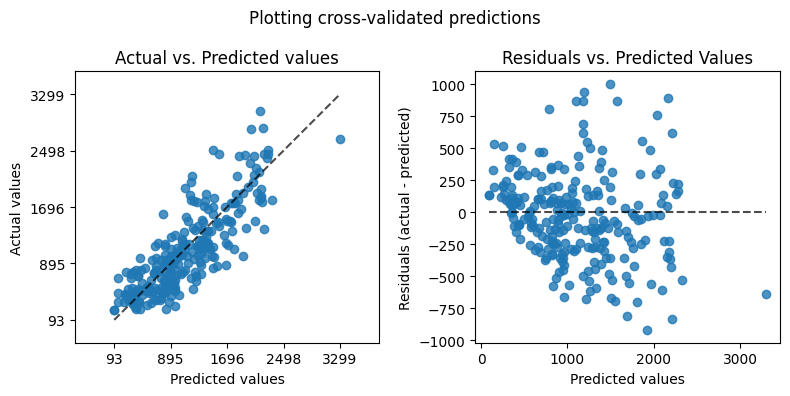

In [25]:
print("Report da Regressão:  \n")
print("R2:", np.round(r2_score(y_test, y_test_lr_hat), 2), "\n")
print("MAE:", np.round(mean_absolute_error(y_test, y_test_lr_hat), 2), "\n")


fig, axs = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_lr_hat,
    kind="actual_vs_predicted",
    ax=axs[0],
)
axs[0].set_title("Actual vs. Predicted values")
PredictionErrorDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_lr_hat,
    kind="residual_vs_predicted",
    ax=axs[1],
)
axs[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Plotting cross-validated predictions")
plt.tight_layout()
plt.show();

### Gerando Intervalos de Previsão com Conformal Prediction

Vamos reaproveitar a receita do caso anterior:
- Divida os dados nos conjuntos de treinamento e calibração
- Treine o modelo nos dados de treinamento
- Calcular pontuações de não conformidade
- Encontre o limite 𝑞
- Crie intervalos de previsão para novos dados

A principal diferença entre classificação e regressão é a pontuação de não conformidade que usamos: 𝑠(𝑦, 𝑥) = |𝑦 − 𝑓(𝑥)|.

Esta função calcula o residual absoluto da previsão quando o y verdadeiro é usado nesta fórmula. Conformizar esta pontuação significa encontrar o limiar 𝑞 onde o nível de confiança 1 − 𝛼 das previsões tem uma pontuação abaixo dela e 𝛼 tem uma pontuação acima dela. Para calcular o intervalo de previsão para um novo ponto de dados, incluímos todos os y's possíveis que produzem uma pontuação abaixo de 𝑞.

Agora, vamos gerar os Intervalos de Previsão (IP) com a lib MAPIE. Vamos assumir um alpha de 33% (ou intervalo de 67%).

In [26]:
mapie_reg = MapieRegressor(estimator=pipe_lr, cv="prefit")
mapie_reg.fit(X_calib, y_calib)
y_pred, y_pis = mapie_reg.predict(X_new, alpha=1/3)

Ótimo! Agora vamos trabalhar com os resultados. Vamos dar uma olhada nos IPs do quinto notebook da base.

In [27]:
print(X_new.iloc[4])
print("------- Notebook por Ram(GB) -------")
print("Preço real: {:.2f}".format(y_new.iloc[4]))
print("Preço predito: {:.2f}".format(y_pred[4]))
interval = y_pis[4].flatten()
print("Intervalo 67%: [{:.2f};{:.2f}]".format(interval[0], interval[1]))

laptop_ID                              83
Company                             Apple
Product                       MacBook 12"
TypeName                        Ultrabook
Inches                             12.000
OpSys                               macOS
Ram(GB)                                 8
Weight(Kg)                          0.920
Resolution                      2304x1440
Screentype          IPSPanelRetinaDisplay
Touchscreen                         0.000
CpuFreq(GHz)                        1.300
CpuBrand                            Intel
GpuBrand                            Intel
Memory_1_sto(GB)                  512.000
Memory_1_type                         SSD
Memory_2_sto(GB)                    0.000
Memory_2_type                         NaN
Name: 81, dtype: object
------- Notebook por Ram(GB) -------
Preço real: 1510.00
Preço predito: 1168.59
Intervalo 67%: [828.91;1508.26]


Agora, vamos verificar a relação entre o preço e algumas features. Vamos gerar um dataframe com as features transformadas pelo pipeline. E definiremos uma função que recebe o nome da feature e produz um gráfico de dispersão que inclui os IPs.

In [28]:
X_new_transformed = pd.DataFrame(
    pipe_lr[0].fit_transform(X_new),
    columns = pipe_lr[0].get_feature_names_out()
)

X_new_transformed

,passthrough__Inches,passthrough__Ram(GB),passthrough__Weight(Kg),passthrough__CpuFreq(GHz),passthrough__Memory_1_sto(GB),passthrough__Memory_2_sto(GB),"gapencoder__Product: probook, vivobook, zenbook","gapencoder__Product: thinkpad, ideapad, 17ikb","gapencoder__Product: ab002nv, an010nv, ak002nv","gapencoder__Product: inspiron, aspire, 7779","gapencoder__Product: gl753vd, gc082t, ge72vr","gapencoder__Product: legion, 15ikbn, 15ikb","gapencoder__Product: latitude, surface, e5570","gapencoder__Product: elitebook, notebook, chromebook","gapencoder__Product: tp501ua, geforce, fx502vm","gapencoder__Product: ax040wm, vostro, stream"
0,14.000,4.000,1.440,1.600,32.000,0.000,0.054,0.055,0.064,0.054,0.056,0.051,0.053,0.056,0.051,22.506
1,15.600,4.000,1.630,2.000,128.000,0.000,13.526,0.050,0.050,0.051,0.050,0.050,0.050,0.069,0.050,0.053
2,15.600,16.000,2.400,2.800,512.000,0.000,0.050,0.058,0.050,0.056,0.050,24.035,0.050,0.050,0.050,0.050
3,15.600,8.000,2.080,1.800,1000.000,0.000,0.053,0.051,0.051,16.514,0.050,0.054,0.073,0.050,0.050,0.054
4,12.000,8.000,0.920,1.300,512.000,0.000,9.331,0.052,0.055,0.051,0.053,0.051,0.053,4.250,0.050,0.054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,15.600,4.000,2.180,2.500,1000.000,0.000,0.053,0.052,0.050,0.054,0.050,0.050,0.050,0.050,0.050,13.540
99,15.600,4.000,2.380,2.500,500.000,0.000,0.052,16.460,0.056,0.093,0.059,0.052,0.069,0.051,0.050,0.058
100,15.600,8.000,2.000,2.000,256.000,0.000,0.053,0.052,0.050,0.054,0.050,0.050,0.050,0.050,0.050,13.540
101,17.300,8.000,2.800,2.500,1000.000,0.000,0.050,22.512,0.051,0.051,0.051,0.080,0.052,0.051,0.051,0.052


In [29]:
# Plots the quantile range of predicted values for given feature

def plot_quantile_by_feature(X, y, pred, qrs, feature_name):
    """
    - X (pandas DataFrame): Dataframe with features for the data.
    - y (pandas Series): Pandas series with the target variable.
    - pred (array-like): An array with predictions.
    - qrs (array-like): Quantile range for plotting.
    - feature_name (string): The name of the feature being plotted.
    """
    xj= X[feature_name]
    # Sort the feature values
    order = np.argsort(xj.values)
    
    # Create a scatter plot of the actual values
    plt.scatter(xj, y.values, color="black", alpha=1/3)
    
    # Plot lower and upper quantile in dashed lines
    plt.plot(xj.values[order], qrs[order][:,0], color="C1", ls="--", linewidth=0.6)
    plt.plot(xj.values[order], qrs[order][:,1], color="C1", ls="--", linewidth=0.6)
    
    # Paint the region between the quantiles
    plt.fill_between(xj.values[order].ravel(),
                     qrs[order][:,0].ravel(),
                     qrs[order][:,1].ravel(),
                     alpha=0.3)
    
    # Label the x-axis with the feature name
    plt.xlabel(feature_name)
    
    # Label the y-axis with the label "predicted rent per sqm"
    plt.ylabel("Preço Previsto por Feature")

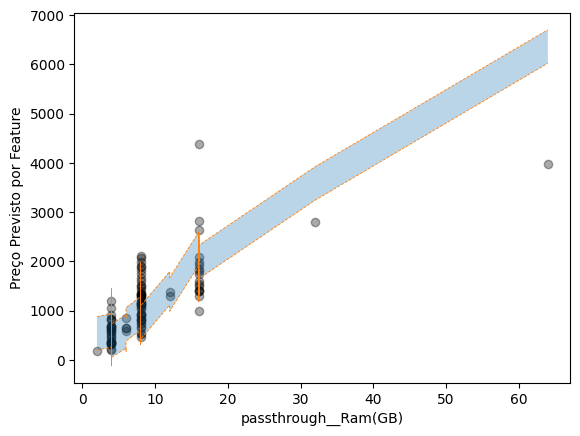

In [30]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_pis, "passthrough__Ram(GB)")

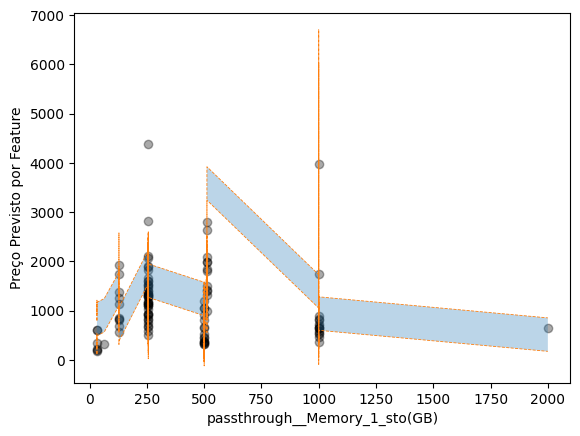

In [31]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_pis, "passthrough__Memory_1_sto(GB)")

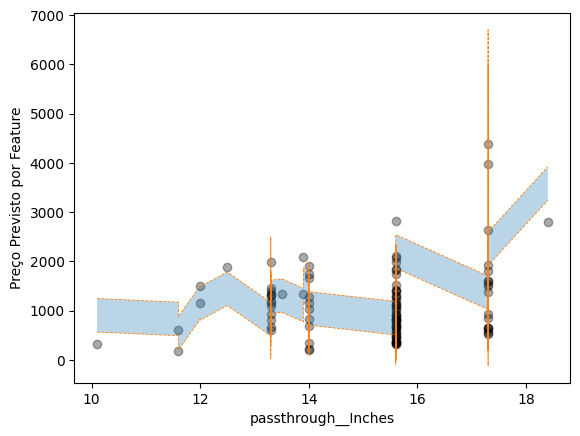

In [32]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_pis, "passthrough__Inches")

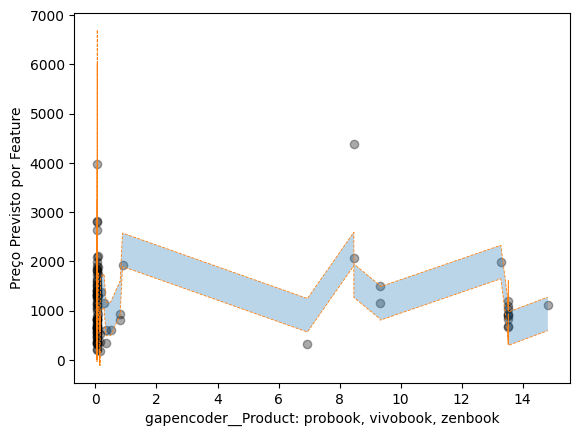

In [33]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_pis, "gapencoder__Product: probook, vivobook, zenbook")

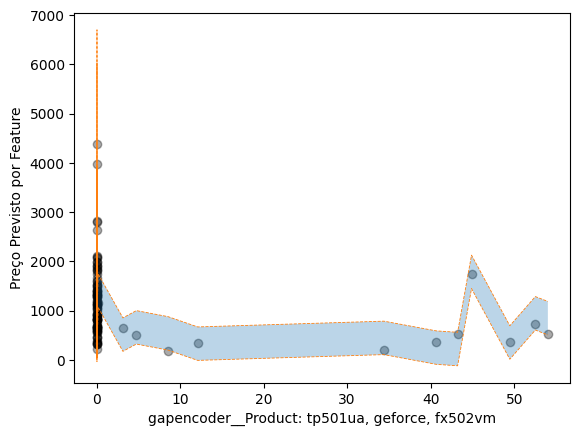

In [34]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_pis, "gapencoder__Product: tp501ua, geforce, fx502vm")

Com alguns dados novos restantes, podemos verificar quão grandes são os intervalos de previsão. MAPIE fornece algumas funções convenientes para avaliar larguras ("width") e cobertura ("coverage") de intervalos de predição.

In [35]:
size = regression_mean_width_score(y_pis[:,0], y_pis[:,1])
print("Avg. interval size: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_pis[:,0], y_pis[:,1])
print("Coverage: {:.2%}".format(cov))

Avg. interval size: 679.34
Coverage: 66.99%


### Gerando Intervalos de Previsão com Conformal Prediction

A outra maneira de criar intervalos de predição conformes é começar com dois modelos de regressão quantílica e aplicar Previsão Conforme e obter o intervalo entre eles. Isso significa que você precisa de um modelo para o quantil inferior e outro para o quantil superior do target, que no nosso caso é o aluguel por metro quadrado.

Dois modelos de regressão quantílica já fornecem intervalos de previsão, mas não há garantia formal de que, para dados futuros, os intervalos terão a cobertura desejada do resultado verdadeiro. Traduzido para o caso de uso: O intervalo do quantil 1/6 (17%) estimado ao quantil 5/6 (83%)estimado pode ou não conter 2/3 (66%) dos dados. Felizmente, podemos usar previsão conforme para garantir a cobertura.

Sendo assim, surge a Regressão Quantílica Conformalizada ("Conformalized Quantile Regression" ou CQR).

É um método destinado a corrigir os intervalos fornecidos pelo modelo de regressão quantílica, de forma que o número de erros observados em novos dados esteja muito próximo da tolerância que você definiu. Tolerância (ou 𝛼), é a porcentagem de erros (ou seja, observações que ficam fora dos intervalos previstos) que você está disposto a aceitar.

Em detalhes, as etapas são:

- Ajustar o modelo de regressão quantil no conjunto de treinamento
- Usar o modelo obtido na etapa anterior para prever intervalos nos dados de calibração
- Calcule os score de conformidades nos dados de calibração e intervalos obtidos na etapa anterior
- Obtenha o quantil 1 - 𝛼 da distribuição das pontuações de conformidade obtidas anterior
- Use o modelo obtido na etapa 1 para fazer previsões sobre o conjunto de teste
- Calcule a extremidade esquerda (direita) do intervalo subtraindo (adicionando) o quantil obtido na etapa 4 às previsões obtidas no ponto 5.

In [38]:
alphas = [1/6, 5/6, 0.5]
models = []

for a in alphas:
    m = make_pipeline(
        encoder,
        QuantileRegressor(solver='highs', quantile=a)
    )
    
    m.fit(X_train, y_train)
    models.append(m)

In [39]:
cqr = MapieQuantileRegressor(models, alpha=1/3, cv="prefit")
cqr.fit(X_calib, y_calib)
y_pred, y_qr = cqr.predict(X_new, alpha = 1/3)

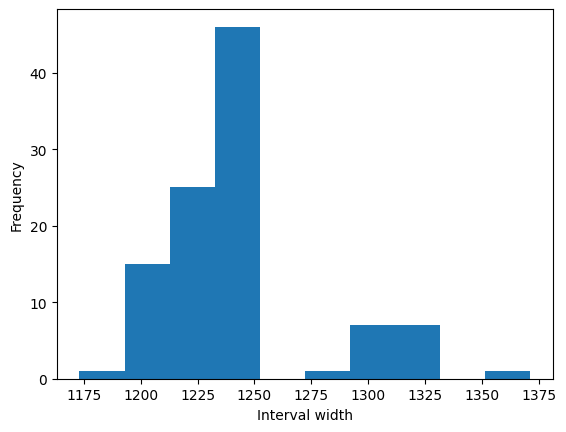

In [40]:
# Calcule as distancias entre as margens superiores e inferiores
widths = y_qr[:,1] - y_qr[:,0]
plt.hist(widths)
plt.xlabel("Interval width")
plt.ylabel("Frequency")
plt.show()

In [41]:
for i in range(5):
    print("%.3f [%.3f;%.3f]" % (y_pred[i], y_qr[i,0], y_qr[i,1]))

881.969 [412.367;1660.000]
863.558 [416.000;1660.000]
1152.878 [430.532;1660.000]
794.005 [449.000;1660.000]
902.875 [430.532;1660.000]


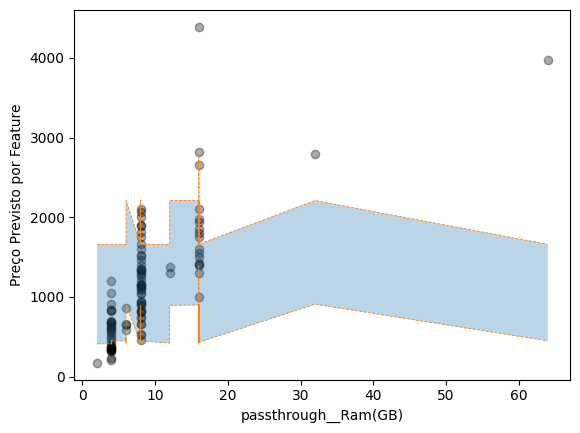

In [42]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_qr, "passthrough__Ram(GB)")

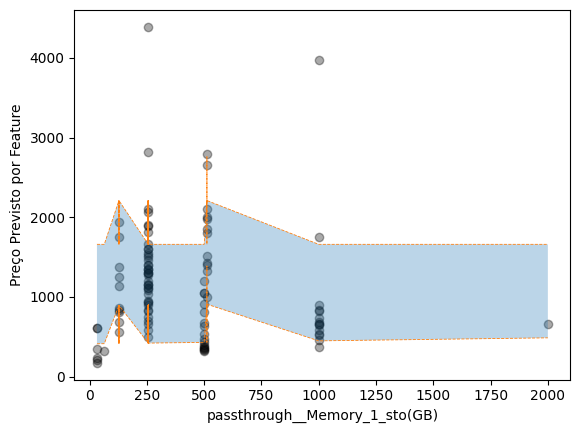

In [43]:
plot_quantile_by_feature(X_new_transformed, y_new, y_pred, y_qr, "passthrough__Memory_1_sto(GB)")

In [44]:
size = regression_mean_width_score(y_qr[:,0], y_qr[:,1])
print("Average interval width: {:.2f}".format(size))
cov = regression_coverage_score(y_new, y_qr[:,0], y_qr[:,1])
print("Coverage: {:.2%}".format(cov))

Average interval width: 1244.24
Coverage: 70.87%


# ----------------------------------------------------------------